In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

# Make everything work with eps list
# Comment and delete old methods
# Make sure all imports are relevant


ModuleNotFoundError: No module named 'qiskit'

In [ ]:
# def main():
# Initialize the simulation parameters
N = 2

gamma_L= 0.5
gamma_R = 0.1

eps = 0.5

mu_L= 0.1
mu_R= 5

T_L = 10
T_R= 0.1

beta_L=1/T_L
beta_R=1/T_R
F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

J = 1

eps_list = []

for i in range(N):
    eps_list.append(0.5)


time = 20
dt = 0.1
nt = int(time/dt)



exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

print("Exact Ham", exact_diag_ham)


ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R,J)


print("Ham real", ham_real)

print("Ham imag", ham_imag)

hopping_ham = SparsePauliOp(["XXII", "YYII", "IIXX", "IIYY"], coeffs=[J, J, -J, -J])



vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)

exact_diag_results, superoperator = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)
print(exact_diag_results)
vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)

# # Output results
output_results(vqte_results, exact_diag_results, time, nt)

Exact Ham [[0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 2. +0.j 0. +0.j]
 [0. +0.j 2. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 1. +0.j]]
Ham real SparsePauliOp(['ZIII', 'IIZI', 'IZII', 'IIIZ', 'XIYI', 'YIXI', 'IYIX', 'IXIY', 'XXII', 'IIXX', 'YYII', 'IIYY'],
              coeffs=[ 0.25      +0.j, -0.25      +0.j,  0.25      +0.j, -0.25      +0.j,
 -0.00249967+0.j, -0.00249967+0.j,  0.025     +0.j,  0.025     +0.j,
 -1.        +0.j,  1.        +0.j, -1.        +0.j,  1.        +0.j])
Ham imag SparsePauliOp(['XIXI', 'YIYI', 'IIII', 'ZIII', 'IIZI', 'IXIX', 'IYIY', 'IIII', 'IZII', 'IIIZ'],
              coeffs=[-0.125     +0.j,  0.125     +0.j,  0.25      +0.j, -0.00249967+0.j,
 -0.00249967+0.j, -0.025     +0.j,  0.025     +0.j,  0.05      +0.j,
  0.025     +0.j,  0.025     +0.j])
Exact diag initial: -9.797174393178812e-16
Exact diag initial: -9.797174393178816e-16
Exact step  1  out of 200
Exact step  2  out of 200
Exact step  3  out of 200
Exact step  4  out of 200
Exact ste

KeyboardInterrupt: 

In [ ]:
h_total = superoperator * 1j
h_herm = (h_total + h_total.getH())/2
np.allclose(ham_real.to_matrix(), h_herm)

True

In [ ]:
h_total = superoperator * 1j
anti_herm = (h_total - h_total.getH())/(2j)
np.allclose(ham_imag.to_matrix(), - anti_herm)

True

Starting VQTE simulations without qiskit_dynamics...


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit_algorithms\time_evolvers\variational\variational_principles\real_mc_lachlan_principle.py:161: UserWarning: A gradient instance with a setting for calculating real part of thegradient was provided. This variational principle requires theimaginary part. The setting to imaginary was changed automatically.
  warnings.warn(


Converged at step 73 with expectation value 0.8501
Converged at step 44 with expectation value 0.8507
Converged at step 32 with expectation value 0.8509
Converged at step 25 with expectation value 0.8509
Converged at step 82 with expectation value 0.8524
Converged at step 82 with expectation value 0.8524
Converged at step 20 with expectation value 0.1409
Converged at step 20 with expectation value 0.1409
Converged at step 82 with expectation value 0.8499


KeyboardInterrupt: 

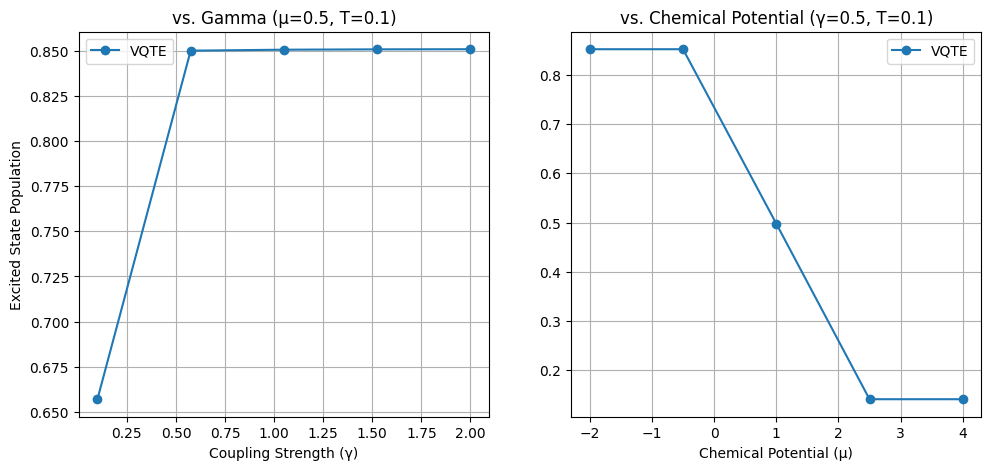

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_algorithms import TimeEvolutionProblem, VarQRTE, VarQITE
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple, ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.gradients import ReverseQGT, ReverseEstimatorGradient
from qiskit.primitives import Estimator, Sampler

# --- Helper Functions ---

def fermi_dirac(energy, mu, T, k_B=1.0):
    """Calculates the Fermi-Dirac distribution."""
    if T < 1e-9: # Avoid division by zero at T=0
        return 1.0 if energy < mu else 0.0
    arg = (energy - mu) / (k_B * T)
    # Avoid overflow for large arguments in exp
    if arg > 500:
        return 0.0
    return 1.0 / (np.exp(arg) + 1.0)

def statevector_to_densitymatrix(v):
    """Converts a vectorized density matrix back to its matrix form."""
    m = int(np.sqrt(len(v)))
    return np.reshape(v, (m, m), order='F')

def liouvillian_generation(eps, gamma, mu, T):
    """
    Generates the Liouvillian for a single qubit coupled to a fermionic bath.
    """
    # System Hamiltonian
    H = 0.5 * eps * SparsePauliOp("Z")
    
    # Define jump operators
    sm = SparsePauliOp("X", coeffs=[0.5]) + SparsePauliOp("Y", coeffs=[0.5j])
    sp = SparsePauliOp("X", coeffs=[0.5]) - SparsePauliOp("Y", coeffs=[0.5j])

    # Thermal occupation from Fermi-Dirac distribution
    n_th = fermi_dirac(eps, mu, T)

    # Collapse operators
    c_ops = []
    # Decay
    if gamma * (1 - n_th) > 0:
        c_ops.append(np.sqrt(gamma * (1 - n_th)) * sm)
    # Excitation
    if gamma * n_th > 0:
        c_ops.append(np.sqrt(gamma * n_th) * sp)

    # Construct the Liouvillian using the qiskit.quantum_info.Lindblad class
    # The Liouvillian L is such that d(rho)/dt = L(rho)
    from qiskit.quantum_info.operators.channel import Lindblad
    lindblad = Lindblad(H, c_ops)
    L = lindblad.to_operator() # This is the Liouvillian superoperator

    # The VQTE simulates d(psi)/dt = -i * H_eff * psi, where psi = vec(rho)
    # So, we need H_eff = i * L
    H_eff = 1j * L

    # Decompose H_eff into real and imaginary parts (both must be Hermitian)
    H_re = 0.5 * (H_eff + H_eff.adjoint())
    H_im = -0.5j * (H_eff - H_eff.adjoint())

    return H_re, H_im


def perform_vqte(ham_real, ham_imag, ansatz, init_param_values, convergence_threshold=1e-4, max_steps=100):
    """
    Performs the VQTE simulation to find the steady state.
    """
    dt = 0.1 # Time step
    
    # Define variational principles
    real_var_principle = RealMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())
    imag_var_principle = ImaginaryMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())

    # The observable is the population of the excited state |1>, which is rho_11
    # In the vectorized picture, this corresponds to the operator |1><1| (x) I
    # For a 2-qubit system representing the density matrix, this is (I-Z)/2 (x) I
    num_op = SparsePauliOp("ZI", coeffs=[-0.5]) + SparsePauliOp("II", coeffs=[0.5])

    param_values = init_param_values
    last_exp_val = -1

    for t in range(max_steps):
        # Imaginary time evolution to find the ground state of H_re (part of finding the null space)
        evolution_problem_im = TimeEvolutionProblem(ham_imag, dt)
        var_qite = VarQITE(ansatz, param_values, imag_var_principle)
        evolution_result_im = var_qite.evolve(evolution_problem_im)
        param_values = evolution_result_im.parameter_values[-1]

        # Real time evolution
        evolution_problem_re = TimeEvolutionProblem(ham_real, dt)
        var_qrte = VarQRTE(ansatz, param_values, real_var_principle)
        evolution_result_re = var_qrte.evolve(evolution_problem_re)
        param_values = evolution_result_re.parameter_values[-1]
        
        # Calculate expectation value
        psi = Statevector(ansatz.assign_parameters(param_values))
        exp_val = psi.expectation_value(num_op).real
        
        # Check for convergence
        if abs(exp_val - last_exp_val) < convergence_threshold:
            print(f"Converged at step {t} with expectation value {exp_val:.4f}")
            return exp_val
        last_exp_val = exp_val

    print("Warning: VQTE did not converge within max steps.")
    return last_exp_val

# --- Simulation Parameters ---
eps = 1.0  # Energy splitting
num_qubits = 1 # 2 qubits to represent the 2x2 density matrix
ansatz = EfficientSU2(num_qubits, reps=1)
initial_parameters = np.full(ansatz.num_parameters, 2 * np.pi)
# --- 1. Plot vs. Gamma ---
gamma_list = np.linspace(0.1, 2.0, 10)
mu_fixed = 0.5
T_fixed = 0.1
pop_vs_gamma = []
for g in gamma_list:
    print(f"\n--- Running for Gamma = {g:.2f} ---")
    H_re, H_im = liouvillian_generation(eps, g, mu_fixed, T_fixed)
    ss_pop = perform_vqte(H_re, H_im, ansatz, initial_parameters)
    pop_vs_gamma.append(ss_pop)

# --- 2. Plot vs. Mu ---
mu_list = np.linspace(-2.0, 4.0, 10)
gamma_fixed = 0.5
T_fixed = 0.1
pop_vs_mu = []
for m in mu_list:
    print(f"\n--- Running for Mu = {m:.2f} ---")
    H_re, H_im = liouvillian_generation(eps, gamma_fixed, m, T_fixed)
    ss_pop = perform_vqte(H_re, H_im, ansatz, initial_parameters)
    pop_vs_mu.append(ss_pop)

# --- 3. Plot vs. Temperature ---
temp_list = np.linspace(0.1, 2.0, 10)
gamma_fixed = 0.5
mu_fixed = 0.5
pop_vs_temp = []
for T in temp_list:
    print(f"\n--- Running for Temp = {T:.2f} ---")
    H_re, H_im = liouvillian_generation(eps, gamma_fixed, mu_fixed, T)
    ss_pop = perform_vqte(H_re, H_im, ansatz, initial_parameters)
    pop_vs_temp.append(ss_pop)

# --- Plotting Results ---
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(gamma_list, pop_vs_gamma, 'o-', label='VQTE')
plt.title(f"vs. Gamma (μ={mu_fixed}, T={T_fixed})")
plt.xlabel("Coupling Strength (γ)")
plt.ylabel("Excited State Population")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(mu_list, pop_vs_mu, 'o-', label='VQTE')
plt.title(f"vs. Chemical Potential (γ={gamma_fixed}, T={T_fixed})")
plt.xlabel("Chemical Potential (μ)")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(temp_list, pop_vs_temp, 'o-', label='VQTE')
plt.title(f"vs. Temperature (γ={gamma_fixed}, μ={mu_fixed})")
plt.xlabel("Temperature (T)")
plt.grid(True)

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_algorithms import TimeEvolutionProblem, VarQRTE, VarQITE
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple, ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.gradients import ReverseQGT, ReverseEstimatorGradient

# --- Physical Constants and Operators ---
Sigma_x = np.array([[0, 1], [1, 0]])
Sigma_y = np.array([[0, -1j], [1j, 0]])
Sigma_z = np.array([[1, 0], [0, -1]])
Sigma_plus = 0.5 * (Sigma_x - 1j * Sigma_y)  # Corrected definition
Sigma_minus = 0.5 * (Sigma_x + 1j * Sigma_y) # Corrected definition
number_op = np.array([[0, 0], [0, 1]])      # |1><1|
I2 = np.eye(2)

# --- Helper Function ---
def fermi_dirac(energy, mu, T, k_B=1.0):
    """Calculates the Fermi-Dirac distribution."""
    if T < 1e-9:
        return 1.0 if energy < mu else 0.0
    arg = (energy - mu) / (k_B * T)
    if arg > 500: return 0.0
    return 1.0 / (np.exp(arg) + 1.0)

# --- Exact Diagonalization Method (Simplified for N=1) ---

def get_exact_steady_state(H, gamma, F):
    """
    Finds the steady state density matrix for N=1 by finding the null space of the Liouvillian.
    """
    # Lindblad operators for a single site coupled to a bath
    L_ops = [
        np.sqrt(gamma * (1 - F)) * Sigma_minus,  # Decay
        np.sqrt(gamma * F) * Sigma_plus        # Excitation
    ]

    # Manually construct the Liouvillian
    d = 2
    superH = -1j * (np.kron(I2, H) - np.kron(H.T, I2))
    superL = sum([np.kron(L.conjugate(), L)
                  - 0.5 * (np.kron(I2, L.conjugate().T @ L) +
                           np.kron((L.T @ L.conjugate()), I2))
                  for L in L_ops])
    
    Superoperator = superH + superL

    # Find the eigenvector with eigenvalue closest to 0
    eigenvalues, eigenvectors = np.linalg.eig(Superoperator)
    ss_vector = eigenvectors[:, np.argmin(np.abs(eigenvalues))]
    
    # Reshape and normalize to get the density matrix
    rho_ss = ss_vector.reshape(d, d, order='F')
    rho_ss = rho_ss / np.trace(rho_ss)

    # Calculate the expectation value of the number operator
    ss_population = np.real(np.trace(number_op @ rho_ss))

    return ss_population, Superoperator

# --- VQTE Method (Simplified for N=1) ---

def perform_vqte(Superoperator, convergence_threshold=1e-5, max_steps=100, dt=0.2):
    """Performs VQTE to find the steady-state population."""
    # Convert Liouvillian to VQTE Hamiltonians
    H_eff = Operator(1j * Superoperator)
    H_re = 0.5 * (H_eff + H_eff.adjoint())
    H_im = -0.5j * (H_eff - H_eff.adjoint())

    # VQTE setup for 2 qubits (to represent the 2x2 density matrix)
    ansatz = EfficientSU2(2, reps=1)
    param_values = np.random.rand(ansatz.num_parameters) # Random initial parameters

    # VQTE observable for population: (I kron I - Z kron I) / 2
    vqte_number_op = 0.5 * SparsePauliOp("II") - 0.5 * SparsePauliOp("ZI")

    # Variational principles
    real_var_principle = RealMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())
    imag_var_principle = ImaginaryMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())
    
    last_exp_val = -1
    for t in range(max_steps):
        # Evolve with imaginary part of H_eff
        evolution_problem_im = TimeEvolutionProblem(H_im, dt)
        var_qite = VarQITE(ansatz, param_values, imag_var_principle)
        param_values = var_qite.evolve(evolution_problem_im).parameter_values[-1]
        
        # Evolve with real part of H_eff
        evolution_problem_re = TimeEvolutionProblem(H_re, dt)
        var_qrte = VarQRTE(ansatz, param_values, real_var_principle)
        param_values = var_qrte.evolve(evolution_problem_re).parameter_values[-1]

        # Check for convergence
        psi = Statevector(ansatz.assign_parameters(param_values))
        current_exp_val = psi.expectation_value(vqte_number_op).real
        
        if np.abs(current_exp_val - last_exp_val) < convergence_threshold:
            # print(f"VQTE Converged at step {t}")
            return current_exp_val
        last_exp_val = current_exp_val
    
    # print("Warning: VQTE did not converge.")
    return last_exp_val

# --- Main Simulation and Plotting ---
if __name__ == "__main__":
    # System Parameters
    epsilon = 1.0  # On-site energy
    gamma = 0.5    # Coupling strength to the bath
    H = 0.5 * epsilon * (I2 - Sigma_z)  # Hamiltonian H = ε * a†a

    # --- 1. Scan over Chemical Potential (mu) ---
    print("Calculating vs. Chemical Potential...")
    mu_list = np.linspace(-1.0, 3.0, 15)
    T_fixed = 0.1
    exact_pops_mu = []
    vqte_pops_mu = []
    
    for mu in mu_list:
        F = fermi_dirac(epsilon, mu, T_fixed)
        exact_pop, L = get_exact_steady_state(H, gamma, F)
        vqte_pop = perform_vqte(L)
        exact_pops_mu.append(exact_pop)
        vqte_pops_mu.append(vqte_pop)

    # --- 2. Scan over Temperature (T) ---
    print(" Calculating vs. Temperature...")
    temp_list = np.linspace(0.01, 1.5, 15)
    mu_fixed = 0.5
    exact_pops_T = []
    vqte_pops_T = []

    for T in temp_list:
        F = fermi_dirac(epsilon, mu_fixed, T)
        exact_pop, L = get_exact_steady_state(H, gamma, F)
        vqte_pop = perform_vqte(L)
        exact_pops_T.append(exact_pop)
        vqte_pops_T.append(vqte_pop)

    # --- 3. Generate Plots ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot vs. Mu
    ax1.plot(mu_list, exact_pops_mu, 'o-', label='Exact Diagonalization', color='royalblue')
    ax1.plot(mu_list, vqte_pops_mu, 'x--', label='VQTE', color='orangered')
    ax1.set_title(f'Steady State vs. Chemical Potential (T={T_fixed})')
    ax1.set_xlabel('Chemical Potential (μ)')
    ax1.set_ylabel('Site Population <n>')
    ax1.legend()

    # Plot vs. Temperature
    ax2.plot(temp_list, exact_pops_T, 'o-', label='Exact Diagonalization', color='royalblue')
    ax2.plot(temp_list, vqte_pops_T, 'x--', label='VQTE', color='orangered')
    ax2.set_title(f'Steady State vs. Temperature (μ={mu_fixed})')
    ax2.set_xlabel('Temperature (T)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

🔬 Calculating vs. Chemical Potential...


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit_algorithms\time_evolvers\variational\variational_principles\real_mc_lachlan_principle.py:161: UserWarning: A gradient instance with a setting for calculating real part of thegradient was provided. This variational principle requires theimaginary part. The setting to imaginary was changed automatically.
  warnings.warn(


🌡️ Calculating vs. Temperature...
